In [1]:
import numpy as np
import cv2
from PIL import Image
import socket
# import shutil
# from skimage import io

class State:
    def __init__(self, state_data):
        self.state_data = np.asarray(state_data)
  
    def process_state(self):
        pass
  
    def get_batch_tensor(self):
        holder = np.asarray(self.state_data)
        holder.reshape((1, ) + holder.shape)
        return holder
  
    def get_individual_tensor(self):
        return np.asarray(self.state_data)

    def get_shape(self):
        return self.state_data.shape
  
    def display(self):
        print(self.state_data)
        
# ------------------------------------

class Frame(State):
    def __init__(self, state_data, crop_factor=None, destination_size=None, vert_cent=0.5):
        State.__init__(self, state_data)
#         self.state_data = self.process_state(crop_factor, vert_cent, destination_shape)
        self.state_data = self.process_state([0.7, 1.0], 0.7, (128,128))
  
    def process_state(self, crop_factor, vert_cent, destination_shape):
        """
        Does all the processing of the frame using the helper functions
        """
        frame = self.crop_frame(self.state_data, crop_factor, vert_cent)
        frame = self.normalise_frame(frame)
        frame = self.gray_scale(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        assert len(frame.shape) == 2
        frame = self.downsample_frame(frame, destination_shape)
        return frame

  
    def gray_scale(self, frame, gray_scale_factor=[0.3, 0.3, 0.3]):
        frame = np.dot(frame, np.asarray(gray_scale_factor))
        return frame

    def normalise_frame(self, frame):
        frame = frame.astype('float32') / 255.0
        return frame
  
    def downsample_frame(self, frame, destination_shape):
        """
        downsamples the frame. decreases the resolution
        """
        frame = cv2.resize(np.asarray(frame), dsize=destination_shape, interpolation=cv2.INTER_CUBIC)
        return frame
  
    def crop_frame(self, frame, crop_factor, vert_cent):
        """
        input is the frame
        output is the cropped frame
        crop_factor is the ratio at which you want to crop the height and width
        cent is the ratio at which the centre of the cropped frame should be
        """
        if crop_factor is None:
          return frame
    
        height_factor = int((crop_factor[0]*frame.shape[0]) // 2)
        width_factor = int((crop_factor[1]*frame.shape[1]) // 2)
        vert_cent = int(frame.shape[0]*vert_cent)
        width_cent = int(frame.shape[1]*0.5)

        frame = frame[vert_cent - height_factor: vert_cent + height_factor, 
                      width_cent - width_factor: width_cent + width_factor]
        return frame

# ------------------------------------
class DataBuffer:
    """
    Keeps track of n latest states 
    """
  
    def __init__(self, size=1):
        self.buffer = []
        self.size = size

    def get_input_tensor(self, in_batch=True):
        arr = np.array(self.buffer)
        if self.size == 1 or in_batch:
            return arr
        else:
            return arr.reshape((1, ) + arr.shape)
    
    def get_input_shape(self):
        return np.asarray(self.current_state[0]).shape

    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        self.buffer.append(state)
        
# ------------------------------------

class FrameBuffer(DataBuffer):
    def __init__(self, size = 4):
        DataBuffer.__init__(self, size=size)
    
    def get_input_shape(self):
        return self.get_input_tensor().shape
  
    def get_input_tensor(self, in_batch=True):
        temp = np.array(self.buffer)
        return  temp.transpose((1, 2, 0))
    
    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        # if buffer not initialised
        if len(self.buffer) == 0:
            self.buffer = [state]
            return

        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        
        self.buffer.append(state)

In [2]:
from pathlib import Path
import os
import os.path
import random

class EnvironmentWrapper:
    
    def __init__(self):
        
        
        # initialise comms with the simulator here
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # initialise the socket
        # connect to localhost, port 2345 
        self.sock.bind(("127.0.0.1", 4444))
        self.sock.listen(1)
        print("Waiting to connect to Simulator...")
        self.clientsocket, _ = self.sock.accept() # connect to simulator [BLOCKING]
        print("Connected to simulator!")
        # =========================================
        
        
        # initialising frame buffer
        self.buffer_size = 4 # could change this 
        
         # this is the FrameBuffer that keeps track of the latest frames.
         #initialising the frame buffer by just giving it multiple copies of the same starting frame
        # =========================================
        
        self.current_state = None
        
        self.current_buffer = None
        
        self.prev_dist = 0
        
        self.time_steps = 0
        
        self.done = False
        
        self.max_time_steps_per_episode = 500 #change this based on the enviorment
        
        
        # =========================================
        
        
        # Create target directory if it doesn't exist
       
        parent_path = os.path.abspath(os.path.join("", os.pardir))
        self.final_path = parent_path + "/simulation/Screenshots"
        if not os.path.exists(self.final_path):
            os.mkdir(self.final_path)
            print("Directory " , self.final_path,  " Created ")
        else:    
            print("Directory " , self.final_path,  " already exists")
            
        # reset actually initializes self.current_state, self.current_buffer etc.
        self.reset()
        
        
        
        self.action_space = ['as', 'ar', 'al', 'ds', 'dr', 'dl', 'bs', 'br', 'bl']
        
    
    
    def get_input_shape(self):
        """
        returns the input shape for the input layer of the network
        """
        return self.current_buffer.get_input_shape()
    
#     def get_state_shape(self):
#         """
#         not to be confused with the input shape. This is the shape of individual state (the shape of an individual processed shape of the environment)
#         """
#         return self.current_state
    
    def get_random_action(self):
        """
        returns a random action to be taken. [steering, acceleration, brake]
        """
        return random.choice(self.action_space)
    
    def get_action_at_index(self, index):
        return self.action_space[index]
    
    def get_num_action_space(self):
        """
        returns the number of permuations of valide actions. For Eg. [steer left, accelerate and no brake] is ONE action
        [steer right, accelerate and brake] is invalid as we cannot accelerate and brake at the same time.
        there are 9 possible actions I think?
        """
        return len(self.action_space)
    
    def reset(self):
        """
        resets the environment. self.done denotes whether the episode is done i.e. the car has crashed or we have stopped it
        """
        self.done = False
        self.time_steps = 0
        
        tup = self.step('reset') # initial step. Says don't do anything but send the first 4 frames and game info
        self.current_state, _, self.done = tup
        return self.current_state[0]
        
    
    def step(self, action):
        """ 
        does the action and returns the reward for that action along with the next state

        This function may get complicated as it has to interact with the car simulator throught sockets.
        """
        self.time_steps += 1
        
        if not self.is_done():
            # if the episode has not ended
            #=======================
            # in this section of the code, we wait for the simulator for to give us an action request
            # then we give it an action through the TCP/IP protocol
            msg = self.receive_message()
            # print("1:{0}".format(msg))
            if msg == 'requesting action':
                # send the action
                self.send_message(action)
                # print("2: sent action")
                # now wait for the action to be completed
                action_done = self.receive_message()
                # print("3:{0}".format(action_done))
                # the 4 images will be stored as scr{i}.png
                
                self.current_buffer = FrameBuffer(size = self.buffer_size)
                
                for i in range(1, self.buffer_size + 1):
                    # each Frame object is then assigned to the FrameBuffer class in chronological order
                    path = self.final_path + '/scr{0}.png'.format(i)
                    self.current_buffer.assign_to_buffer(self.get_frame(path))
                
                # print("4: requesting info")
                angle, distance, speed, self.done = self.get_game_stats()
                # print("5: info:{0}, {1}, {2}, {3}".format(angle, distance, speed, self.done))

                dist_delta = self.prev_dist - distance
                
                self.prev_dist = distance

                if abs(dist_delta) > 30:
                    dist_delta = 5 # if there's too big a negative jump in the distance, the car has passed a checkpoint.
                    # so, don't penalise it for that.

                # calculate reward based on the game stats 
                reward = (dist_delta * 0.7) + (speed * 0.3) - (abs(angle) * 0.1)
                
                buffer_tensor = self.current_buffer.get_input_tensor()

            # this buffer tensor is what we will input to the NN in the next time step
            # we record this as the next observation.
            
            # A buffer is a collection of consecutive frames that we feed to the NN. These frames are already processed.
            
            self.current_state = (buffer_tensor, angle, distance, speed)

            # this returns the state of the environment after the action has been completed, the reward for the action and if the episode ended.
            return self.current_state , reward, self.done
        else:
            return None
    
    def send_message(self, string):
        self.clientsocket.sendall(string.encode())
    
    def receive_message(self):
        data  = self.clientsocket.recv(256).decode()
        return data
    
    
    def is_done(self):
        """
        returns if the episode is finished
        """
        return self.done
        
    
    def get_frame(self, path: str) -> Frame:
        """
        communicates with the sim to get the latest state/frame. 
        returns a Frame object
        Get image from path then convert to np array then make a frame object
        """
        image = Image.open(path, 'r')
        image.load()
        np_data = np.asarray(image, dtype="float32" )
        return Frame(np_data)
    
    
    # def delete_screenshots(self, folder_path: str) -> None:
    #     """
    #     This method deletes the four screenshots saved in folder_path, along with the entire folder.
    #     Method must be called after all four screenshots are converted to Frame objects.
    #     """
    #     shutil.rmtree(folder_path)
    
    
    def get_current_state():
        """
        get the last n frames from the simulator (they might be stored in a folder by the simulator)
        and store them in a buffer and return them
        """
        return self.current_buff

    
    def get_game_stats(self):
        """
        returns a tuple of angle, distance from checkpoint and speed from the sim. Again requires comms with simulator.
        """
        self.send_message("requesting info")
        string = self.receive_message()
        self.send_message("got it")
        
        value_list = string.split(", ")
        angle = float(value_list[0])
        distance = float(value_list[1])
        speed = float(value_list[2])

        crashed_state = False
        if value_list[3] == '1':
            crashed_state = True
        return (angle, distance, speed, crashed_state)
    
    def close(self):
        """
        in case we need to 'close' the environment
        """
        self.sock.close()
        self.clientsocket.close()


In [3]:
# Testing connection
# import random
# data = []
# env = EnvironmentWrapper()
# for i in range(10000):
#    data.append(env.step("ar"))

In [4]:
class Agent:
    def __init__(self, environment, network, run_only=False, eps_decay_rate=0.9975,max_exp_rate=1.0, min_exp_rate=0.05):
        self.env = environment # this should be the environment wrapper class
        
        if not run_only:
            self.exp_rate = max_exp_rate     # our network starts off with this exploration rate
        else:
            self.exp_rate = 0.0
        
        self.min_exp_rate = min_exp_rate  # have at least 0.01 exploration rate at all times
        
        self.decay_rate = eps_decay_rate   # decay the exploration rate at this rate
        
        self.time_step = 0     # keeps track of time steps
        
        self.network = network
    
    def take_action(self, current_state):
        # Implement the epsilon greedy strategy 
        result = random.random()                      # get a random number from 0 to 1 with linear distribution
        if result > self.get_exp_rate():              # if it falls over the explore rate, exploit
            action = self.env.get_action_at_index(self.network.get_max_q_value_index(current_state))  # exploit
            
        else:                                         # if it falls under the explore rate, explore
            action = self.env.get_random_action()          # explore (generate a random action from the environment class)
            
        self.increment_time_step()                    # increment time step as well as update the decay rate
        next_state, reward, done = self.env.step(action)# finally, take the action and record the reward
        
        return current_state, self.env.action_space.index(action), reward, next_state[0], done  # return an experience Tuple
        
    
    def reset_time_steps(self, i=0):
        self.timesteps = i
    
    def increment_time_step(self):
        self.time_step += 1
    
    def update_epsilon(self):
        if self.exp_rate > self.min_exp_rate:
            self.exp_rate = self.exp_rate * self.decay_rate
        else:
            self.exp_rate = self.min_exp_rate
    
    def get_exp_rate(self):
        return self.exp_rate

In [5]:
network_name = 'DrivePolicy.h5'
from keras import layers, models
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
class NetworkTracker:
    
    def __init__(self, environment, source=False): # pass in the environment which has input shape of the frame
        if source:
            self.model = models.load_model(network_name)
        else:
            self.model = self.define_model(environment)
            self.model.save(network_name)
        self.target_model = self.model
              
    def define_model(self, env):
        model = models.Sequential() 
        model.add(layers.Conv2D(filters=10, 
                                kernel_size=(3,3), 
                                activation='relu', 
                                input_shape=env.get_input_shape())) # first layer takes input shape from the environment
        
        model.add(layers.MaxPool2D((3, 3)))
        
        model.add(layers.Conv2D(filters=20, kernel_size = (3, 3), stride=2, activation='relu'))

        model.add(layers.MaxPool2D(3, 3))
        
        model.add(layers.Flatten())
        
        model.add(layers.Dense(16, activation='softmax'))
        
        model.add(layers.Dense(16, activation='relu'))
        
        model.add(layers.Dense(env.get_num_action_space(), activation='linear'))
        
        model.compile(optimizer='adam',
                           loss='mse')
        return model
    
    def get_q_values_for_one(self, state):
        
        output_tensor = self.model.predict(state.reshape((1, ) + state.shape )) # the State class handles turning the state 
                                                                    # into an appropriate input tensor for a NN
                                                                    # so you don't have to change it everywhere
        return output_tensor[0]  # you want to convert the 2 dimensional output to 1 dimension to call argmax
    
    def get_max_q_value_index(self, state):
        return np.argmax(self.get_q_values_for_one(state))
    
    def get_q_values_for_batch(self, states):
        if states[0] is State:
            states = np.asarray(states)
        
        f = self.model.predict(states)
        
        return f
    
    def get_target_tensor(self, next_states):
        if next_states[0] is State:
            next_states = np.asarray([i.to_input_tensor(individual=False) for i in next_states])
        output_tensor = self.target_model.predict(next_states)
        
        return output_tensor
                  
    def fit(self, states_batch, targets_batch):
        self.model.fit(states_batch, targets_batch, verbose=1)
        
    def clone_policy(self):
        self.model.save(network_name)
        self.target_model = models.load_model(network_name)
                  
    def get_model_summary(self):
        return self.model.summary()

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [6]:
import random
class Memory:
    def __init__(self, size):
        self.replay = []
        self.limit = size
        self.exp_count = 0
    
    def push(self, experience):
        self.exp_count += 1
        
        if self.exp_count < self.limit:
            self.replay.append(experience)  #append to experiences
        else:
            self.replay[self.exp_count%len(self.replay)] = experience  #wrap around if the memory capacity is reached
        assert len(self.replay) <= self.limit
        
    def is_usable(self, batch_size):
        return len(self.replay) >= batch_size
    
    def reset_replay_memory(self):
        self.exp_count = 0
        self.replay = []
        
    def sample(self, batch_size):
        return random.sample(self.replay, batch_size)

In [7]:
def extract_tensors(sample):
    states = np.asarray([i[0] for i in sample])
    actions = np.asarray([i[1] for i in sample])
    rewards = np.asarray([i[2] for i in sample])
    next_states = np.asarray([i[3] for i in sample])
    done_tensor = np.asarray([i[4] for i in sample])
    return states, actions, rewards, next_states, done_tensor

In [8]:
def get_target_batch(states, actions, rewards, next_states, dones, net, gamma):
    assert actions.ndim == 1
    assert rewards.ndim == 1
    assert dones.ndim == 1
    assert len(actions) == len(rewards) == len(dones) == len(states) == len(next_states)
    target_q_values = net.get_q_values_for_batch(states)
    targets = rewards + gamma * (np.max(net.get_target_tensor(next_states), axis=1))
    for i in range(len(targets)):
        if dones[i]:
            targets[i] = rewards[i]
    
    for index in range(len(target_q_values)):
        
        target_q_values[index][actions[index]] = targets[index]

    return target_q_values

In [9]:
import matplotlib.pyplot as plt

def train_agent(verbose=False, num_episodes=1500,
                discount = 0.95, batch_size = 64, N = 40, memory_size = 1024, 
                eps_decay_rate=0.9975, max_exp_rate=1.0, min_exp_rate=0.05):
    # get all the hyperparameters in one place!
    
    # stores all the total reward per episode
    training_stats = []    
    
    # initialise your environment
    env = EnvironmentWrapper()
    
    # initialise your policy and target networks
    net = NetworkTracker(env)
    
    # initialise your agent that will follow the epsilon greedy strategy
    agent = Agent(env, net, eps_decay_rate=eps_decay_rate, max_exp_rate=max_exp_rate,min_exp_rate=min_exp_rate )    
    
    # initialise experience replay memory
    memory = Memory(memory_size)
    
    for episode_count in range(num_episodes):
        state = env.reset()
        # uncomment if you want to start the environmet with a random move
        # state = env.step(env.get_random_action())[0]
        
        # keeps track of the total reward that we got for this episode
        cumulative_reward = 0
        
        stuck_counter = 0
        # check if the environment is available to run
        while not env.is_done(): # run the environment for one episode
            current_state, action, reward, next_state, done = agent.take_action(state)
            cumulative_reward += reward
            experience = current_state, action, reward, next_state, done
            state = next_state
            memory.push(experience)
            if abs(reward) < 0.05:
                stuck_counter += 1
                if stuck_counter > 10:
                    break
            else:
                stuck_counter = 0
                

        
        agent.update_epsilon()
        if memory.is_usable(batch_size):

                experience_batch = memory.sample(batch_size)
                states, actions, rewards, next_states, done_tensor = extract_tensors(experience_batch) # unzips the tensors

                target_batch = get_target_batch(states, actions, rewards, next_states, done_tensor, net, discount)


                net.fit(states, target_batch)

        if (episode_count + 1) % N == 0:
            net.clone_policy()

        training_stats.append(cumulative_reward)
        
        if verbose:
            print("Episode Count: ", episode_count, "\t Cumulative Reward: ", cumulative_reward, "\t eps: ", agent.exp_rate )


    epochs = list(range(len(training_stats)))

    plt.clf
    plt.plot(epochs, training_stats, 'b', label='f')
    env.close()
    
    return epochs, training_stats

In [10]:
env = EnvironmentWrapper()
lmao = []
for i in range(2):
    env.reset()
    while not env.is_done():
        exp = env.step('ds')
        lmao.append(exp)
        

Waiting to connect to Simulator...
Connected to simulator!
Directory  C:\Users\Sohaib Saqib\Documents\GitHub\self-driving-car/simulation/Screenshots  already exists


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [11]:
# train_agent(verbose=True, 
#             num_episodes=100,
#             discount = 0.95, 
#             batch_size = 32, 
#             N = 40, # how often to clone
#             memory_size = 128,
#             eps_decay_rate=0.9997,
#             max_exp_rate=1.0, 
#             min_exp_rate=0.05)

In [12]:
lmao[0]

((array([[[0.57118523, 0.40487369, 0.717383  , 0.63676845],
          [0.60205894, 0.62380931, 0.69944887, 0.74571405],
          [0.6608014 , 0.65810854, 0.62279828, 0.66809392],
          ...,
          [0.40740238, 0.38894443, 0.42087282, 0.31160088],
          [0.45838582, 0.41726658, 0.49147989, 0.45213037],
          [0.49695922, 0.4760954 , 0.47045543, 0.45913766]],
  
         [[0.59945204, 0.64975353, 0.72448224, 0.62412595],
          [0.55226136, 0.52878545, 0.739052  , 0.6475361 ],
          [0.62665255, 0.46473814, 0.71376207, 0.60436118],
          ...,
          [0.33850043, 0.3161724 , 0.24364587, 0.35615277],
          [0.34545947, 0.326068  , 0.38824209, 0.43791346],
          [0.41524493, 0.37530258, 0.44919151, 0.48403383]],
  
         [[0.58798679, 0.6526096 , 0.62933988, 0.5497209 ],
          [0.57364079, 0.60780068, 0.65152825, 0.67604778],
          [0.61218956, 0.54333506, 0.59448106, 0.58122614],
          ...,
          [0.24853606, 0.20206162, 0.43919817, 

In [13]:
lmao[0][0]

(array([[[0.57118523, 0.40487369, 0.717383  , 0.63676845],
         [0.60205894, 0.62380931, 0.69944887, 0.74571405],
         [0.6608014 , 0.65810854, 0.62279828, 0.66809392],
         ...,
         [0.40740238, 0.38894443, 0.42087282, 0.31160088],
         [0.45838582, 0.41726658, 0.49147989, 0.45213037],
         [0.49695922, 0.4760954 , 0.47045543, 0.45913766]],
 
        [[0.59945204, 0.64975353, 0.72448224, 0.62412595],
         [0.55226136, 0.52878545, 0.739052  , 0.6475361 ],
         [0.62665255, 0.46473814, 0.71376207, 0.60436118],
         ...,
         [0.33850043, 0.3161724 , 0.24364587, 0.35615277],
         [0.34545947, 0.326068  , 0.38824209, 0.43791346],
         [0.41524493, 0.37530258, 0.44919151, 0.48403383]],
 
        [[0.58798679, 0.6526096 , 0.62933988, 0.5497209 ],
         [0.57364079, 0.60780068, 0.65152825, 0.67604778],
         [0.61218956, 0.54333506, 0.59448106, 0.58122614],
         ...,
         [0.24853606, 0.20206162, 0.43919817, 0.40172663],
        

In [14]:
lmao[0][0][0]

array([[[0.57118523, 0.40487369, 0.717383  , 0.63676845],
        [0.60205894, 0.62380931, 0.69944887, 0.74571405],
        [0.6608014 , 0.65810854, 0.62279828, 0.66809392],
        ...,
        [0.40740238, 0.38894443, 0.42087282, 0.31160088],
        [0.45838582, 0.41726658, 0.49147989, 0.45213037],
        [0.49695922, 0.4760954 , 0.47045543, 0.45913766]],

       [[0.59945204, 0.64975353, 0.72448224, 0.62412595],
        [0.55226136, 0.52878545, 0.739052  , 0.6475361 ],
        [0.62665255, 0.46473814, 0.71376207, 0.60436118],
        ...,
        [0.33850043, 0.3161724 , 0.24364587, 0.35615277],
        [0.34545947, 0.326068  , 0.38824209, 0.43791346],
        [0.41524493, 0.37530258, 0.44919151, 0.48403383]],

       [[0.58798679, 0.6526096 , 0.62933988, 0.5497209 ],
        [0.57364079, 0.60780068, 0.65152825, 0.67604778],
        [0.61218956, 0.54333506, 0.59448106, 0.58122614],
        ...,
        [0.24853606, 0.20206162, 0.43919817, 0.40172663],
        [0.26548074, 0.244164

In [15]:
import matplotlib.pyplot as plt
print(lmao[20][0][0].shape)
f = lmao[20][0][0].transpose((2, 0, 1))
f.shape

(128, 128, 4)


(4, 128, 128)

In [16]:
f[0].shape

(128, 128)

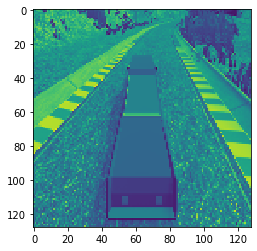

In [17]:
plt.imshow(f[0])

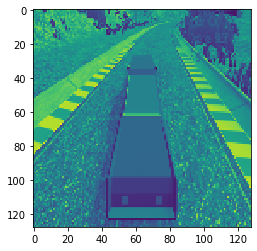

In [18]:
plt.imshow(f[1])

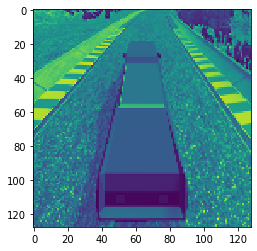

In [21]:
plt.imshow(f[2])